# AIAIART #7 - Diffusion Models and Latent Diffusion

![pulp fiction gif](https://i.makeagif.com/media/1-07-2016/qcLnCS.gif)

It's finally time to look at the latest, greatest, shiniest model type. Diffusion models!!!! We happy?

We'll take a look at the core concept, implement a toy one ourselves, run through the modifications that have been added at different times to turn these into text-to-image systems, and finally take a look at latent diffusion. We'll also do a bit of a detour into what the *model* part of a diffusion model actually looks like in practice.

I'm not an expert on diffusion models, so I've tried to link in as many other resources as I can in the hopes that they can undo any egregious mistakes I make in this lesson :) Here are some key ones for quick reference:

AI Coffee Break - a very accessible video introduction to the topic: https://www.youtube.com/watch?v=344w5h24-h8

Denoising Diffusion Probabilistic Models: Paper (https://arxiv.org/abs/2006.11239) and blog post from the authors (https://hojonathanho.github.io/diffusion/)

Diffusion Models Beat GANs on Image Synthesis (Paper): https://arxiv.org/abs/2105.05233

DDPM - Diffusion Models Beat GANs on Image Synthesis (Machine Learning Research Paper Explained) - Yannic Kilcher on YouTube: https://www.youtube.com/watch?v=W-O7AZNzbzQ (and another video of his on GLIDE: https://www.youtube.com/watch?v=gwI6g1pBD84)

GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models. Paper from OpenAI (https://arxiv.org/abs/2112.10741) and code (https://github.com/openai/glide-text2im)

Dall-e2 paper (aka unCLIP, PDF): https://cdn.openai.com/papers/dall-e-2.pdf



# Section 1: Overview of Diffusion Models

Let's begin by seeing where diffusion models fit within the zoo of generative models in use today:

![model type diag](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)
Overview of different types of generative models. (from [this great blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/))

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains. 
- Train a model to 'undo' these noise steps. 
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image. 

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

With this high-level idea in our heads, let's have a go at implementing one!


# Section 2: Implementing One

![building with blocks gif](https://c.tenor.com/di20fW1AF_MAAAAC/building-blocks-simon-wiggle.gif)

Some of the code in this section is borrowed from [this annotated implementation](https://nn.labml.ai/diffusion/ddpm/index.html), which is worth a read if you want more detail. As with many examples in this course, I've tried to distil this example down to the most simple version.

In [ ]:
# @title Install requirements
!pip install datasets &>> install.log

In [ ]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)



## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

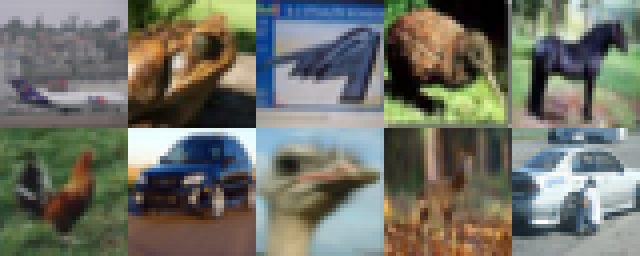

In [ ]:
#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

In [ ]:
# @title alternative dataset: faces (CelebA) - uncomment to run 
# faces = load_dataset('huggan/CelebA-faces')

## 2.2 Adding Noise

First, we want to define the spet that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

![process](https://datasciencecastnethome.files.wordpress.com/2022/04/screenshot-from-2022-04-12-14-55-09.png) ([Image source](https://hojonathanho.github.io/diffusion/))

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

Scary! But not too bad once we break it down. We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

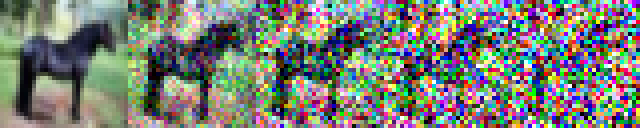

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
  mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
  var = gather(beta, t) # βt I
  eps = torch.randn_like(xtm1) # Noise shaped like xtm1
  return mean + (var ** 0.5) * eps

# Show im at different stages
ims = []
start_im = cifar10['train'][4]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))
  
  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37. 

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$. 

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$

Again, the code is far less scary:

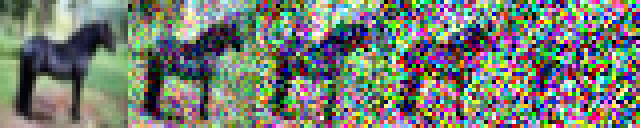

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
  var = 1-gather(alpha_bar, t) # (1-alpha_bar)
  eps = torch.randn_like(x0)
  return mean + (var ** 0.5) * eps

# Show im at different stages
ims = []
start_im = cifar10['train'][4]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

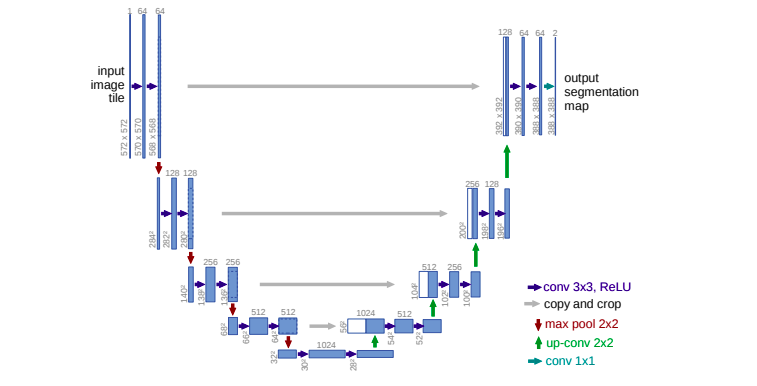

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers. 

These networks turned out to be great at all sorts of image-to-image tasks. Colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention (it's all you need!) and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks. 

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding 
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [ ]:
# Let's see it in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

torch.Size([10, 3, 32, 32])

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. You don't **have** to do it this way, but the papers do, and we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

This training loop should look familiar from all the past lessons!

In [ ]:
unet = UNet(n_channels=32).cuda()

n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps, eps # also returns noise

batch_size = 128 # Lower this if hitting memory issues
lr = 2e-4 # Explore this - might want it lower when training on the full dataset

losses = []

dataset = cifar10['train']#.select(range(10000)) # to use a 10k subset for demo

optim = torch.optim.AdamW(unet.parameters(), lr=lr)

for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Run through the dataset
  optim.zero_grad() # Zero the gradients
  ims = [dataset[idx]['img'] for idx in range(i,i+batch_size)] # Fetch some imegs
  tims = [img_to_tensor(im).cuda() for im in ims] # Convert to tensors
  x0 = torch.cat(tims) # Combine into a batch
  t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda() # Random 't's 
  xt, noise = q_xt_x0(x0, t) # Get the noised images (xt) and the noise (our target)
  pred_noise = unet(xt.float(), t) # Run xt through the network to get its predictions
  loss = F.mse_loss(noise.float(), pred_noise) # Compare the predictions with the targets
  losses.append(loss.item()) # Store the loss for later viewing
  loss.backward() # Backpropagate the loss
  optim.step() # Update the network parameters

  0%|          | 0/390 [00:00<?, ?it/s]

NB: You'd typically create a dataloader to run through a dataset in batches like we did above, but I couldn't remember the syntax and forgot to fix it! Hopefully the way I did it here is clear enough :)

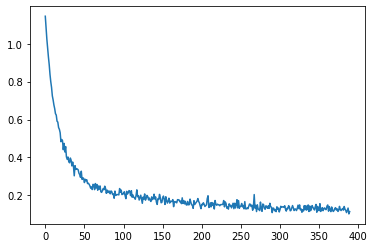

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

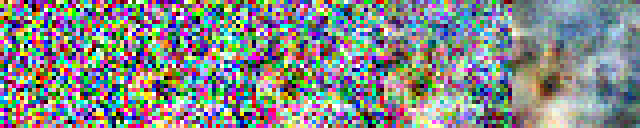

In [ ]:
def p_xt(xt, noise, t):
  alpha_t = gather(alpha, t)
  alpha_bar_t = gather(alpha_bar, t)
  eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
  mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise) # Note minus sign
  var = gather(beta, t)
  eps = torch.randn(xt.shape, device=xt.device)
  return mean + (var ** 0.5) * eps 

x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%24 == 0:
      ims.append(tensor_to_image(x.cpu()))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Perfect? No... Oh well, let's try a few more times:

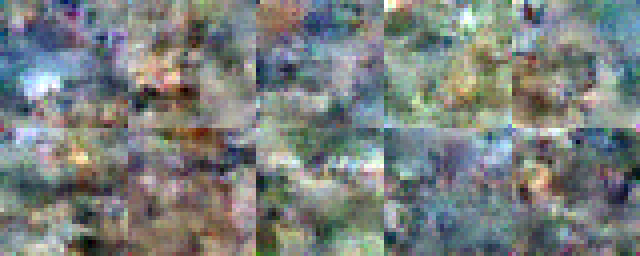

In [ ]:
#@title Make and show 10 examples:
x = torch.randn(10, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)

We're only training here with 100 noise steps, and perhaps the model mostly sees images with at least a little bit of structure to them. If we start with a half-noised image can it at least 'fix' it back to something like the original?

torch.Size([10, 3, 32, 32])


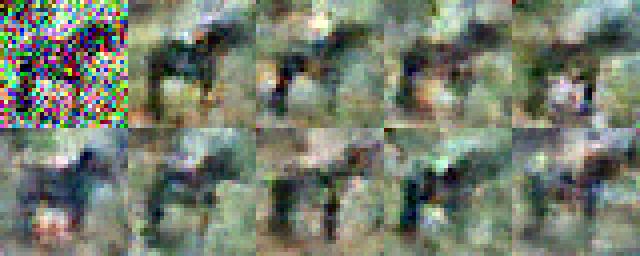

In [ ]:
#@title Start with a heavily noised horse (t=50, top left = starting point):
horse = cifar10['train'][4]['img']
x0 = img_to_tensor(horse)
x = torch.cat([q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0] for _ in range(10)] )
example_start = q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0]
print(x.shape)
ims = []
for i in range(50, n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
  if i==0:image.paste(tensor_to_image(example_start.unsqueeze(0).cpu()), ((i%5)*32, 32*(i//5))) # Show the heavily noised starting point top left
image.resize((32*4*5, 32*4*2), Image.NEAREST)

##2.7  Getting to paper quality

In the DDPM paper (https://arxiv.org/abs/2006.11239) they train their CIFAR10 model on a TPU v3-8 (similar to 8 V100 GPUs) at 21
steps per second at batch size 128 (10.6 hours to train to completion at 800k steps). So a little more training than our example above!

Sampling a batch of 256 images takes 17 seconds. They also use dropout (rate 0.1) to try to combat overfitting. LR is 2e-4. They use 1000 steps for everything. Later papers use as many as 4000 steps, with a slight resultant increase in quality.

What about size of the model? Their model is something like 37 million parameters. We can get a rough estimate for ours with:



In [ ]:
sum([p.flatten().shape[0] for p in UNet(n_channels=32).parameters()]) # Pretty close in this case

42253539

In [ ]:
sum([p.flatten().shape[0] for p in UNet().parameters()]) # Default (64 channels) gives 168 million params!

168899011

We can probably do a little better than the above with a few tweaks, but it's going to take patience to get a good model even at these low resolutions. Skip to the end and I train one on the celebA dataset which is more similar images (all faces). At 64px resolution after an hour or so we get some recognizeable outputs!

## 2.8 Sampling Tricks

![robot climbing stairs gif](https://i.pinimg.com/originals/32/1f/c8/321fc86152a9ece7da8c82f6cec9312c.gif)

Doing 1000 reverse steps gets old quick, so some different approaches have popped up to try and reduce the number of model passes required. Most involve some variant of using the model outputs to skip some steps. We won't go into further detail, but here are a couple of papers introducing key ideas:

DDIM (Song et al) https://arxiv.org/abs/2010.02502

Pseudo Numerical Methods for Diffusion Models on Manifolds (Liu et al) https://arxiv.org/abs/2202.09778

Key idea: with clever tricks we can get decent samples in 25 or 50 steps rather than 1000 as in the original formulation. You'll see e.g. 'PLMS' as an option in most of the diffusion notebooks floating around.

# Section 3: Guided diffusion models (Text-to-image)

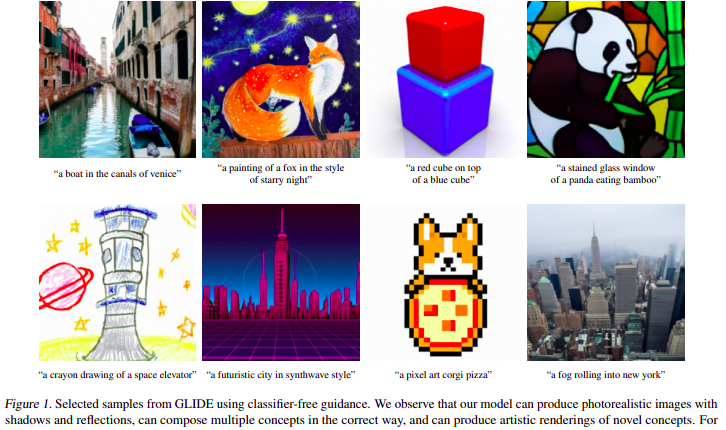[Image source](https://arxiv.org/abs/2112.10741)

There are a few different ways to add text into this process so that we can 'steer' the generation. 

GLIDE mini demo: https://huggingface.co/spaces/valhalla/glide-text2im

## 3.1 Conditioning



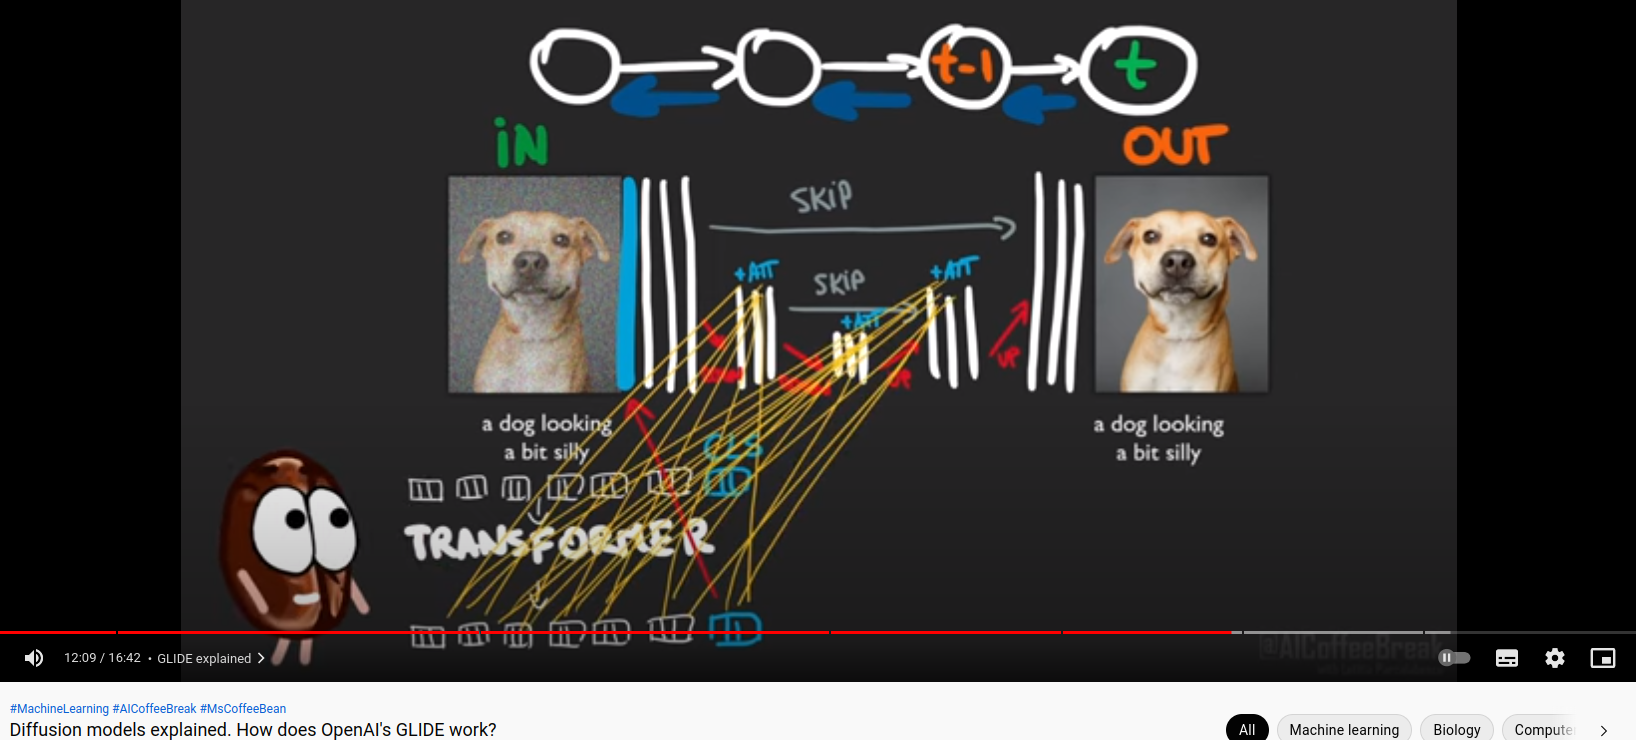

Here some encoding of the text (often from a pre-trained language model) is fed into the unet as extra 'conditioning' information. In the GLIDE paper (explained in the [video shown above](https://www.youtube.com/watch?v=344w5h24-h8)) they found this didn't work super well on it's own, so they tried forcing the model to pay more attention (pun intended) by injecting all the encoded tokens and having various layers attend to that data as well.

You could do this in other ways. For example, go back to the code for the unet up in SECTION X - see how we add an encoded version of `t` in there? We could just as easily also pass in an encoded representation of a text caption (e.g. a CLIP embedding) or a label at that point as well. 

##3.2 Guided Diffusion (Classifier Guidance)

<!-- ![dog walking gif](https://media4.giphy.com/media/n7VasukVCpiGk/giphy.gif)
![dog walking dog](https://www.donnasbigredchair.love/wp-content/uploads/2016/04/dog-walking-dog.jpg) -->
![dog walking dog](https://pawprints-n-hoofbeats.com/wp-content/uploads/2012/08/large.jpg)

When text conditioning wasn't enough, the GLIDE authors tried guiding the process further using a second model (the 'classifier'). Remember how we can use CLIP to 'score' how well an image matches a prompt? During inference, the intermediate images are fed through CLIP and the gradient of the loss with respect to each pixel is calculated. Then in addition the the update proposed by the diffusion model (the unet) they also tweak the individual pixels a little based on the CLIP loss. So the secondary model (here CLIP) sort of nudges things in the right direction a little at each step.

You can also do classifier guidance by combining a diffusion model with a classifier that has been trained to assign a specific class to an image, For example, with cifar10 you could train a CNN on the labels ('horse', 'car' etc) and use that to try and guide the diffusion model towards generating that class of images. In fact that might be a good piece of homework for anyone feeling particularly smart! If you manage it let me know :)

##3.3 Classifier Free Guidance

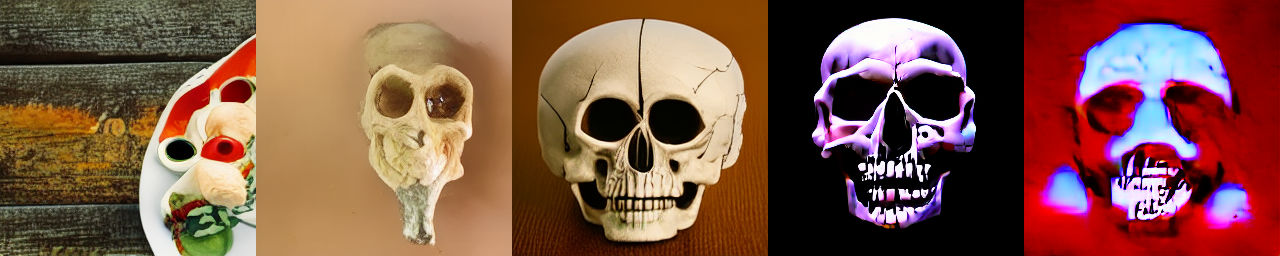

*Results for the prompt 'a skull' with guidance_scale values of 0, 1, 4, 20 and 80 respectively.*

This is a neat trick. The model proposes two updates: one produced using the text conditioning and one without. You can imagine that the update using text conditioning is 'closer' to what we want, and CFG emphasises this direction by taking the difference between the two possible updates and scaling that by some factor (e.g. 5x) to 'push' the process even further in that direction. 

You can experiment with GLID-3 and see this in action. CFG scale 0: random images are produced without any relevance to the text. CFG scale 1: the same as just using text conditioning, and the images do sort of match the prompt but aren't perfect. CFG scale 3, or 5, or 20: more and more emphasis on the text!

GLID-3 Inference Notebook: https://colab.research.google.com/drive/1x4p2PokZ3XznBn35Q5BBD6K6Zs-tot5t?usp=sharing

GLID-3 code: https://github.com/Jack000/glid-3


# Section 4: Further innovations

## 4.1 Latent Diffusion

So that's diffusion models. Neat! We've seen that they can produce lovely images (yay) but take a while to generate (boo) but can be made faster with clever sampling tricks (yay). And we've seen that they can be conditioned on text (yay) but it doesn't work super well (boo) but we can get around this with tricks like CFG (yay). How else can we modify these epic models to be even better?

![compvis latent diffusion results](https://github.com/CompVis/latent-diffusion/raw/main/assets/txt2img-preview.png)
*Examples of images generated with a latent diffusion model. Note the text in the sign - this is far better than the DALL-E 2 model can manage!*



One issue that remains with these diffusion models is that they require a lot of data and compute to train. Because we're running things *for every pixel* of an image, and often doing many steps of processing on these pixels, the computation adds up quickly.

If only we had a way to operate on a more compressed representation of an image... oh wait - we do! Autoencoders, for example, have a latent space where each point in the latent space maps to an output image. What if we do the same sort of diffusion process (starting from an input, gradually adding noise, learning the reverse process) in a latent space rather than on full images? We get latent diffusion!

I've seen these kinds of models using various VQ-GAN models, as well as (more recently) some more custom autoencoder architectures optimised for latent diffusion.

Compvis latent diffusion: https://huggingface.co/spaces/multimodalart/latentdiffusion

Github: https://github.com/CompVis/latent-diffusion


## 4.2 CLOOB-Conditioned Latent Diffusion

![but wait there's more gif](https://y.yarn.co/13c03d95-d4c4-4aa2-80dc-f7994a4c18af_text.gif)

Surely we're done! What else can we improve?

Well, you still need lots of image-caption pairs to train a latent diffusion model. Debatably this is not that big of a deal with open datasets everywhere, but it's still a pain if you want to train (or fine-tune) a model on your own data. 

Enter CLOOB-Conditioned Latent Diffusion!



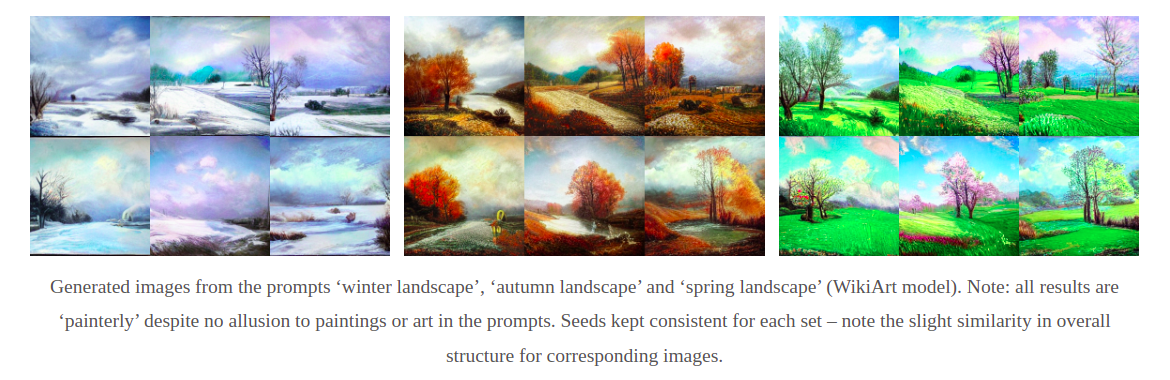

Remember, the text and image embeddings from CLOOB tend to be very similar. So, if we train a latent diffusion model but use the CLOOB embedding of the text as our conditioning, we get a pretty decent model. But if we don't have captions, we can **just use the CLOOB embedding of the IMAGE** as the conditioning during training. So while training we never use any text. But when we now want to generate, we feed in a prompt to CLOOB and it (hopefully) maps to an embedding that is similar to some of the image embeddings the model was trained on, and it spits out a result that ideally matches our text. Crazy, right!

I used [this code](https://github.com/JD-P/cloob-latent-diffusion) to fine-tune a CLOOB-Conditioned Latent Diffusion model on the WikiArt dataset, which doesn't have captions. And yet, as long as you're describing the kind of things in the dataset, it does a fairly decent job generating images to match! [Here's a blog post](https://datasciencecastnet.home.blog/2022/04/12/fine-tuning-a-cloob-conditioned-latent-diffusion-model-on-wikiart/) with more info, and [here's a demo with a smaller model](https://huggingface.co/spaces/huggan/wikiart-diffusion-mini) that you can try out right now. 

# Aaaand done? For now?

This field is evolving very rapidly. There is ongoing work to further refine these ideas (eg https://github.com/NVlabs/denoising-diffusion-gan). 

Who knows what is waiting 'Another two papers down the line...'

But, for the next week or two at least, you should now be able to skim the latest greatest text-to-image system announcements coming out and nod smugly to yourself, secure in the knowledge that you know what some of the words mean ;)

See you in the next lesson, when we retreat from the big news models and play with some fun little toys that are, in their own way, just as special. 

<3 J

# PS: Face Generation with CelebA

I suppose we better follow through and show training our model on the faces dataset.

So YOU don't have to[TM]

In [ ]:
#@title train...
unet = UNet().cuda()

n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# TODO explain
def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps, eps # also returns noise

batch_size = 32
lr = 1e-5

losses = []

dataset = faces['train']

optim = torch.optim.AdamW(unet.parameters(), lr=lr)

for i in tqdm(range(0, len(dataset)-batch_size, batch_size)):
  optim.zero_grad()
  ims = [dataset[idx]['image'].resize((64, 64)) for idx in range(i,i+batch_size)]
  tims = [img_to_tensor(im).cuda() for im in ims]
  x0 = torch.cat(tims)
  t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda()
  xt, noise = q_xt_x0(x0, t)
  pred_noise = unet(xt.float(), t)
  loss = F.mse_loss(noise.float(), pred_noise)
  losses.append(loss.item())
  loss.backward()
  optim.step()

  0%|          | 0/6331 [00:00<?, ?it/s]

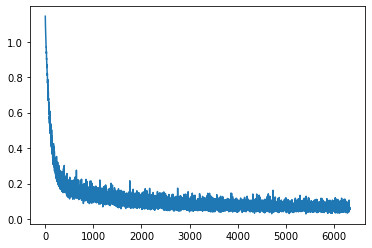

In [ ]:
#@title plot losses
plt.plot(losses)

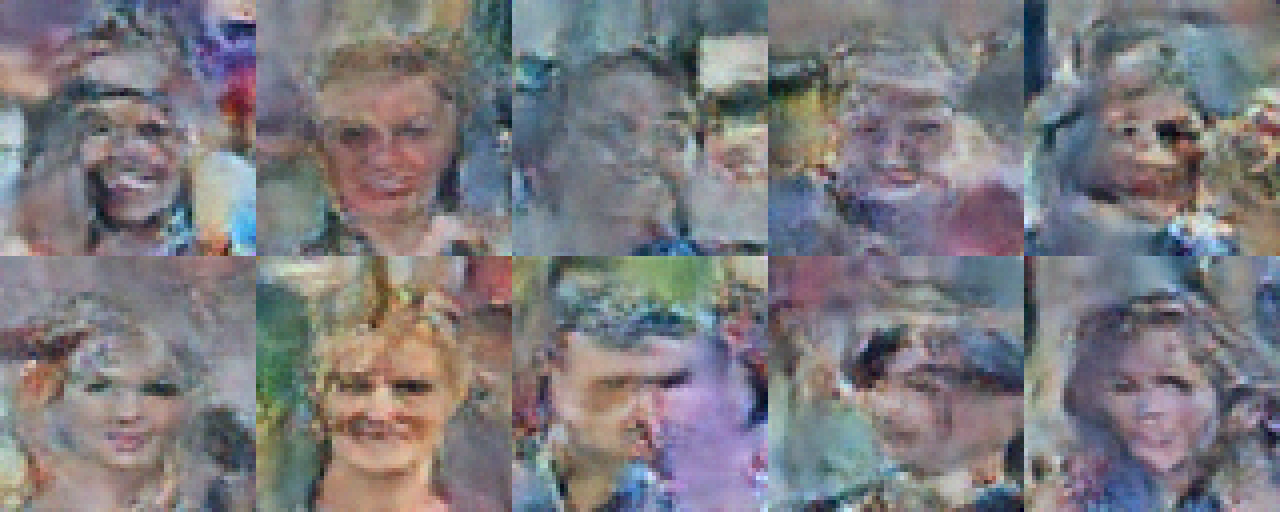

In [ ]:
#@title generate samples
x = torch.randn(10, 3, 64, 64).cuda()
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(64*5, 64*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*64, 64*(i//5)))
image.resize((64*4*5, 64*4*2), Image.NEAREST)

# PPS: Doing it 'properly'

Say you wanted to train a diffusion model that was actually, you know, good. Is it just a matter of running this notebook but with n_steps=1000 and more training for everything? Well, you could try that. But making changes and messing about can be time-consuming, and it's easy to forget what parameters you've tried, what worked best etc. In the lesson video I'll show a little demo of what a fancier approach might look like.

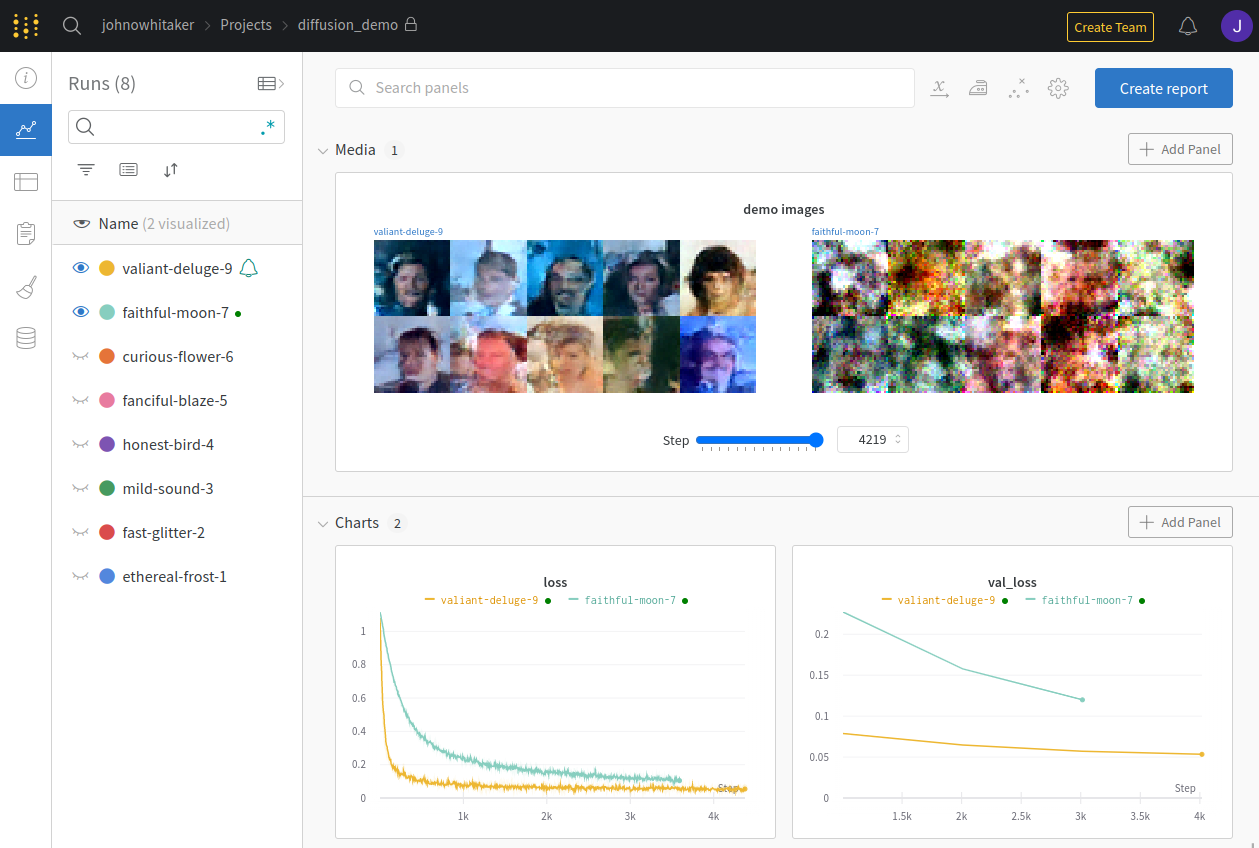

^ The W&B project for this demo, showing two experiments in progress.